In [1]:
import sys
sys.path.append("../SpikeCounter")
from skimage import io as skio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters, morphology, transform, exposure
from scipy import stats, signal, ndimage
import os
from spikecounter import utils
from spikecounter.ui import visualize
import colorcet as cc
from matplotlib import colors
plt.style.use("/n/home11/bjia/bio_pubs_presentation.mplstyle")

In [2]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220805_confocal_gcamp/"
figdir= "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/v8"
filename = "E18-16"

In [3]:
um2 = (0.3980*2)**2
files = ["E18-16", "E6_gcamp-14", "E9_gcamp-04"]

In [4]:
time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % files[0]))

In [5]:
offset_times = time_data["TimeS"] - time_data["TimeS"].iloc[1990]

In [6]:
(1990+1558)/2

1774.0

In [33]:
idx = 0
filename = files[0]
img = skio.imread(os.path.join(rootdir, "%s.tif" % filename))

In [34]:
img.dtype

dtype('uint8')

In [35]:
gaussian_blurred = ndimage.gaussian_filter(img, sigma=(1,2,2))

In [36]:
time_smoothed = ndimage.gaussian_filter(img, sigma=(3,1,1))

In [37]:
tsmoothed_mask = np.copy(time_smoothed).astype(np.float32)
tsmoothed_mask[time_smoothed==0] = np.nan
tsmoothed_mask_uint8 = np.copy(time_smoothed).astype(np.uint8)
tsmoothed_mask_uint8[time_smoothed==0] = 0

In [38]:
skio.imsave(os.path.join(rootdir, "%s_tsmoothed_masked.tif" % filename), tsmoothed_mask_uint8)

In [ ]:
dFF = time_smoothed/np.nanpercentile(tsmoothed_mask, 10, axis=0)

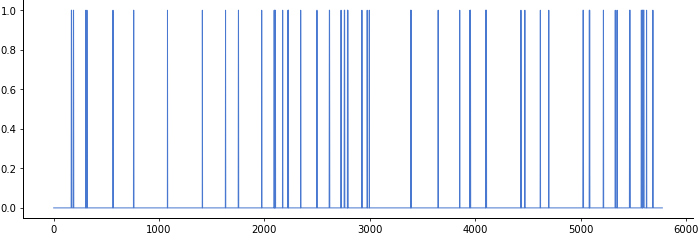

In [10]:
yrand = np.random.randint(img.shape[1])
xrand = np.random.randint(img.shape[2])
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dFF[:,yrand, xrand])

In [11]:
dFF.dtype

dtype('float64')

In [12]:
skio.imsave(os.path.join(rootdir, "%s_dFF.tif" % filename), dFF.astype(np.float32))

In [13]:
skio.imsave(os.path.join(rootdir, "%s_dFF_trunc.tif" % filename), dFF[offsets_new[idx]-100:offsets_new[idx]+100].astype(np.float32))

In [12]:
dFF1 = skio.imread(os.path.join(rootdir, "%s_dFF.tif" % files[0]))

In [21]:
dFF1.shape

(3398, 484, 512)

In [6]:
n_before = 200
n_after = 100
merged_vids = []
for i in range(2):
    dFF = skio.imread(os.path.join(rootdir, "%s_dFF.tif" % files[i]))
    dFF_trunc = dFF[offsets_new[i]-n_before:offsets_new[i]+n_after].astype(np.float32)
    del dFF
    print(dFF_trunc.shape)
    dFF_trunc = exposure.rescale_intensity(dFF_trunc, in_range=(np.nanmin(dFF_trunc),np.nanmax(dFF_trunc)),\
                                        out_range=(0,1)).astype(np.float32)
    snap = skio.imread(os.path.join(rootdir, "MAX_%s_structure-01.ome.tif" % files[i]))
    snap_downscaled = transform.resize(snap, (484, 512)).astype(np.float32)
    snap_downscaled = exposure.rescale_intensity(snap_downscaled, out_range=(0,1)).astype(np.float32)
    structure = np.tile(snap_downscaled, (n_before+n_after, 1, 1))
    merged_vids.append(np.array([dFF_trunc, structure]))

(300, 484, 512)
(300, 484, 512)


In [8]:
merged_vid = np.concatenate(merged_vids, axis=3)

In [13]:
merged_vid.shape

(2, 300, 484, 1024)

In [10]:
skio.imsave(os.path.join(rootdir, "merged_vid.tif"), merged_vid.astype(np.float32))

In [10]:
n_before = 200
n_after = 100
merged_vids = []
for i in range(2):
    dFF = skio.imread(os.path.join(rootdir, "%s_tsmoothed_masked.tif" % files[i]))
    dFF_trunc = dFF[offsets_new[i]-n_before:offsets_new[i]+n_after].astype(np.uint8)
    del dFF
    print(dFF_trunc.dtype)
    snap = skio.imread(os.path.join(rootdir, "MAX_%s_structure-01.ome.tif" % files[i]))
    snap_downscaled = transform.resize(snap, (484, 512)).astype(np.uint8)
    structure = np.tile(snap_downscaled, (n_before+n_after, 1, 1))
    merged_vids.append(np.array([dFF_trunc, structure]))
merged_vid = np.concatenate(merged_vids, axis=3)
print(merged_vid.dtype)
skio.imsave(os.path.join(rootdir, "merged_vid_raw.tif"), merged_vid)

uint8
uint8
uint8


/tmp/ipykernel_141873/1984034488.py:15: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220805_confocal_gcamp/merged_vid_raw.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "merged_vid_raw.tif"), merged_vid)


In [28]:
snap1 = skio.imread(os.path.join(rootdir, "MAX_%s_structure-01.ome.tif" % files[1]))

In [29]:
snap1.shape

(1407, 1487)

In [16]:
time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % files[0]))
np.nanmean(np.diff(time_data["TimeS"]))

0.29982720047100386

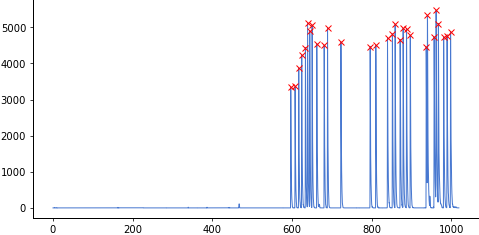

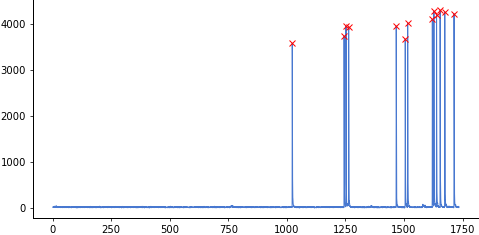

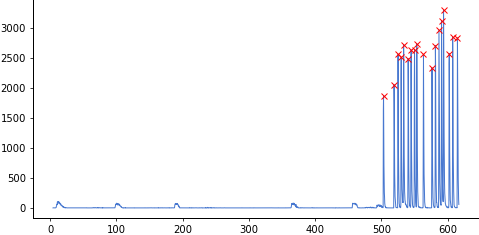

In [7]:
offsets_new = []
for filename in files:
    time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % filename))
    fig1, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(time_data["TimeS"], time_data["area_um"])
    pks, _ = signal.find_peaks(time_data["area_um"].to_numpy(), height=1000)
    ax1.plot(time_data["TimeS"][pks], time_data["area_um"][pks], "rx")
    offsets_new.append(pks[0])

In [19]:
offsets_new

[1990, 3405, 1664]

(<Figure size 720x864 with 1 Axes>,
 <AxesSubplot:>,
 None)

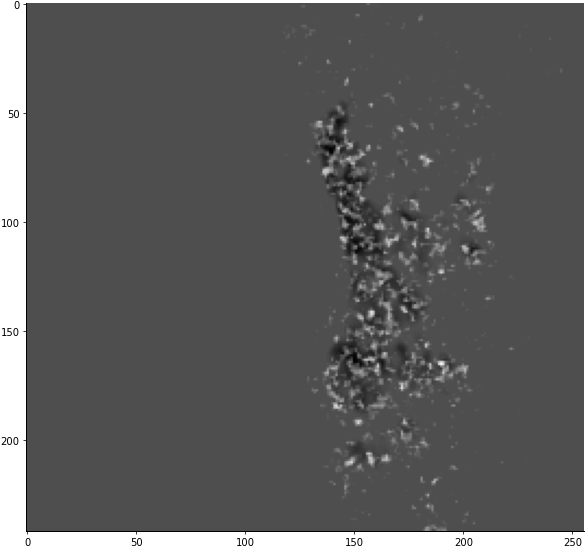

In [230]:
idx = 1000
visualize.display_roi_overlay(dF[idx], dF[idx] > max_value*ratio)

Old data

In [7]:
old_files = ["20201111_E4_t1", "20201113_E1_t4", "20201113_E4_t1"]

In [121]:
area_traces = []

In [157]:
filename2 = "20201113_E4_t1"
img2 = skio.imread(os.path.join(rootdir, "%s.tif" % filename2))[:,0,:,:]


In [158]:
processed2 = ndimage.median_filter(img2, size=(1,3,3))
dF2 = processed2 - np.percentile(processed2, 50, axis=0)

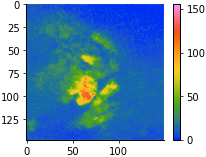

In [159]:
q = plt.imshow(dF2.max(axis=0))
plt.colorbar(q)

In [134]:
um22 = 0.6889
max_value = np.percentile(dF2, 99.9)
print(max_value)

73.0


Ratios
20201111_E4_t1: 0.15
20201113_E1_t4: 0.22
20201113_E4_t1: 0.12

In [212]:
ratio = 0.12
area_trace = (dF2 > max_value*ratio).sum(axis=(1,2))*um22

(<Figure size 720x864 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2b0a4fbbb550>)

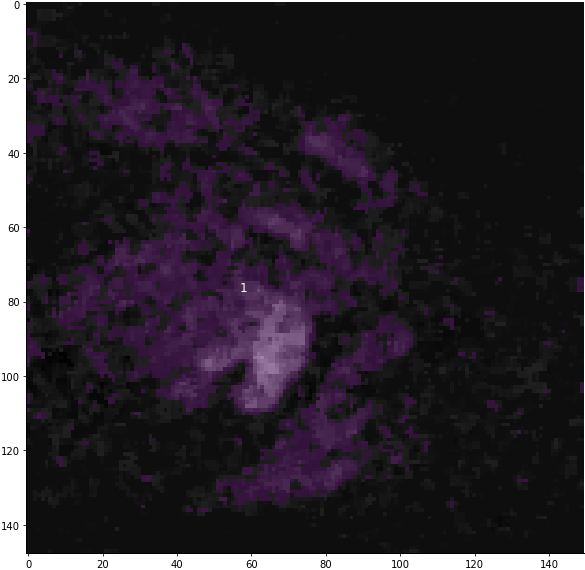

In [213]:
idx = 200
visualize.display_roi_overlay(dF2[idx], dF2[idx] > max_value*ratio)

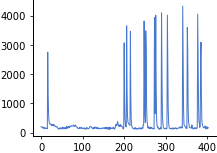

In [214]:
plt.plot(area_trace)

(-100.0, 500.0)

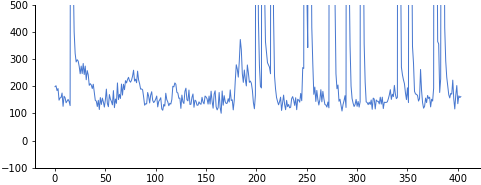

In [215]:
fig1, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(area_trace)
# ax1.set_xlim(1000, 2000)
ax1.set_ylim(-100, 500)

In [216]:
df = pd.DataFrame(area_trace, columns=["area_um2"])
df.to_csv(os.path.join(rootdir, "%s_areas.csv" % filename2), index=False)

In [9]:
offsets = [127, 79, 201]
dt = 1.9

In [246]:
# cmatrix = np.zeros((3,2,3))
# cmatrix[:,1,0] = 1
# # cmatrix[:,0,1:3] = np.array([84,211,204])[:,None]/255
# cmatrix[:,0,1:3] = np.array([140,234,231])[:,None]/255
# cmatrix[:,1,1:3] = np.array([83,154,212])[:,None]/255

# cdict = {'red':   cmatrix[0].tolist(),
#          'green': cmatrix[1].tolist(),
#          'blue':  cmatrix[2].tolist()}

# newcmp = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

In [268]:
cdict

{'red': [[0.0, 0.5490196078431373, 0.5490196078431373],
  [1.0, 0.3254901960784314, 0.3254901960784314]],
 'green': [[0.0, 0.9176470588235294, 0.9176470588235294],
  [1.0, 0.6039215686274509, 0.6039215686274509]],
 'blue': [[0.0, 0.9058823529411765, 0.9058823529411765],
  [1.0, 0.8313725490196079, 0.8313725490196079]]}

In [5]:
# colormap #54d3cc to #539ad4

cmatrix = np.zeros((3,5,3))
cmatrix[:,:,0] = np.arange(cmatrix.shape[1])/(cmatrix.shape[1]-1)
# cmatrix[:,0,1:3] = np.array([84,211,204])[:,None]/255
# cmatrix[:,0,1:3] = np.array([140,234,231])[:,None]/255

# cmatrix[:,1,1:3] = np.array([83,154,212])[:,None]/255

cmatrix[:,0,1:3] = np.array((15,94,156))[:,None]/255
cmatrix[:,1,1:3] = np.array((35,137,218))[:,None]/255
cmatrix[:,2,1:3] = np.array((28,163,236))[:,None]/255
cmatrix[:,3,1:3] = np.array((90,188,216))[:,None]/255
cmatrix[:,4,1:3] = np.array((116,204,244))[:,None]/255

# cmatrix[:,4,1:3] = np.array([179,205,224])[:,None]/255


cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

newcmp = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

Text(0, 0.5, 'Active area ($\\mathrm{\\mu m}^2$)')

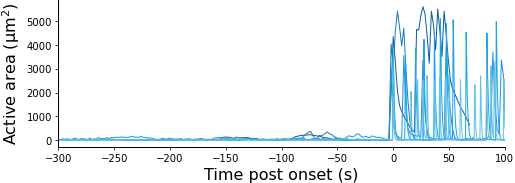

In [10]:
fig1, ax1 = plt.subplots(figsize=(8, 2.7))
for i, of in enumerate(old_files):
    df = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % of))
    ts = np.arange(df.shape[0])*dt
    ax1.plot(ts-ts[offsets[i]], df["area_um2"]-np.min(df["area_um2"]), alpha=1,\
             color=newcmp(i/(len(old_files) + len(files))))
for i, filename in enumerate(files):
    time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % filename))
    times = time_data["TimeS"].to_numpy()
    ax1.plot(times-times[offsets_new[i]], time_data["area_um"],\
            color=newcmp((i+3)/(len(old_files) + len(files))))
#     pks, _ = signal.find_peaks(time_data["area_um"].to_numpy(), height=1000)
#     ax1.plot(time_data["TimeS"][pks], time_data["area_um"][pks], "rx")
#     offsets_new.append(pks[0])
# ts_new = pd.read_csv(os.path.join(rootdir, "%s_plane_table.csv" % filename))["TimeS"]
# ax1.plot(ts_new-ts_new[1991], area_trace, color=newcmp(1))
ax1.set_xlim(-300, 100)
ax1.set_xlabel("Time post onset (s)")
ax1.set_ylabel(r"Active area ($\mathrm{\mu m}^2$)")
# plt.savefig(os.path.join(figdir, "Figure2", "POSTER_active_area_traces.svg"))

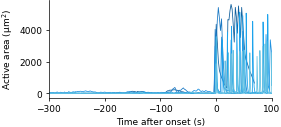

In [11]:
with plt.style.context("/n/home11/bjia/bio_publications.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(4, 1.8))
    for i, of in enumerate(old_files):
        df = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % of))
        ts = np.arange(df.shape[0])*dt
        ax1.plot(ts-ts[offsets[i]], df["area_um2"]-np.min(df["area_um2"]), alpha=1,\
                 color=newcmp(i/(len(old_files) + len(files))))
    for i, filename in enumerate(files):
        time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % filename))
        times = time_data["TimeS"].to_numpy()
        ax1.plot(times-times[offsets_new[i]], time_data["area_um"],\
                color=newcmp((i+3)/(len(old_files) + len(files))))
    #     pks, _ = signal.find_peaks(time_data["area_um"].to_numpy(), height=1000)
    #     ax1.plot(time_data["TimeS"][pks], time_data["area_um"][pks], "rx")
    #     offsets_new.append(pks[0])
    # ts_new = pd.read_csv(os.path.join(rootdir, "%s_plane_table.csv" % filename))["TimeS"]
    # ax1.plot(ts_new-ts_new[1991], area_trace, color=newcmp(1))
    ax1.set_xlim(-300, 100)
    ax1.set_xlabel("Time after onset (s)")
    ax1.set_ylabel(r"Active area ($\mathrm{\mu m}^2$)")
    plt.savefig(os.path.join(figdir, "Figure2", "active_area_traces.svg"))

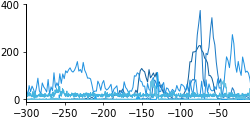

In [31]:
fig1, ax1 = plt.subplots(figsize=(4, 1.8))
for i, of in enumerate(old_files):
    df = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % of))
    ts = np.arange(df.shape[0])*dt
    ax1.plot(ts-ts[offsets[i]], df["area_um2"]-np.min(df["area_um2"]), alpha=1,\
             color=newcmp(i/(len(old_files) + len(files))))
for i, filename in enumerate(files):
    time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % filename))
    times = time_data["TimeS"].to_numpy()
    ax1.plot(times-times[offsets_new[i]], time_data["area_um"],\
            color=newcmp((i+3)/(len(old_files) + len(files))))

# ts_new = pd.read_csv(os.path.join(rootdir, "%s_plane_table.csv" % filename))["TimeS"]
# ax1.plot(ts_new-ts_new[1991], area_trace, color=newcmp(1))
ax1.set_xlim(-300, -10)
ax1.set_ylim(-10, 400)
plt.savefig(os.path.join(figdir, "Figure2", "POSTER_active_area_traces_inset.svg"))

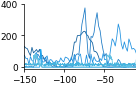

In [36]:
with plt.style.context("/n/home11/bjia/bio_publications.mplstyle"):    
    fig1, ax1 = plt.subplots(figsize=(2, 1.2))
    for i, of in enumerate(old_files):
        df = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % of))
        ts = np.arange(df.shape[0])*dt
        ax1.plot(ts-ts[offsets[i]], df["area_um2"]-np.min(df["area_um2"]), alpha=1,\
                 color=newcmp(i/(len(old_files) + len(files))))
    for i, filename in enumerate(files):
        time_data = pd.read_csv(os.path.join(rootdir, "%s_areas.csv" % filename))
        times = time_data["TimeS"].to_numpy()
        ax1.plot(times-times[offsets_new[i]], time_data["area_um"],\
                color=newcmp((i+3)/(len(old_files) + len(files))))

    # ts_new = pd.read_csv(os.path.join(rootdir, "%s_plane_table.csv" % filename))["TimeS"]
    # ax1.plot(ts_new-ts_new[1991], area_trace, color=newcmp(1))
    ax1.set_xlim(-150, -10)
    ax1.set_ylim(-10, 400)
    plt.savefig(os.path.join(figdir, "Figure2", "active_area_traces_inset.svg"))